In [20]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import xgboost as xgb
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

## Espacios Públicos Gdl

In [3]:
schema = 'espacios_publicos'
table = 'ep_amg'
gdf = aup.gdf_from_db(table,schema)
gdf.head()

,Fuente,Tipo,Uso,geometry
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2..."
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2..."
2,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672494.325 2272095.205, 672480.366 2..."
3,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672480.366 2272060.731, 672494.325 2..."
4,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672468.717 2272020.613, 672456.895 2..."


## Hexágonos Gdl

In [4]:
hex_schema = "raster_analysis"
hex_table = "ndvi_analysis_hex"
c = 'Guadalajara'
n = '11'
query = f'SELECT hex_id, geometry, city FROM {hex_schema}.{hex_table} WHERE \"city\" LIKE \'{c}\' AND \"res\" = {n}'
hex_gdl = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
hex_gdl.head(5)

,hex_id,geometry,city
0,8b49ab4b42d4fff,"POLYGON ((-103.42329 20.71934, -103.42311 20.7...",Guadalajara
1,8b49ab4b42f5fff,"POLYGON ((-103.42428 20.71844, -103.42411 20.7...",Guadalajara
2,8b49ab4b4306fff,"POLYGON ((-103.42486 20.71260, -103.42469 20.7...",Guadalajara
3,8b49ab4b4255fff,"POLYGON ((-103.42703 20.71818, -103.42686 20.7...",Guadalajara
4,8b49ab4b42d6fff,"POLYGON ((-103.42281 20.71955, -103.42264 20.7...",Guadalajara


In [4]:
hex_gdl.shape

(407141, 3)

In [5]:
gdf = gdf.to_crs(hex_gdl.crs)
print("CRS of gdf:", gdf.crs)
print("CRS of hex_gdl:", hex_gdl.crs)

CRS of gdf: epsg:4326
CRS of hex_gdl: epsg:4326


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [6]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdl['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdl['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdl.head()

,hex_id,geometry,city,EspPublico
0,8b49ab4b42d4fff,"POLYGON ((-103.42329 20.71934, -103.42311 20.7...",Guadalajara,0
1,8b49ab4b42f5fff,"POLYGON ((-103.42428 20.71844, -103.42411 20.7...",Guadalajara,0
2,8b49ab4b4306fff,"POLYGON ((-103.42486 20.71260, -103.42469 20.7...",Guadalajara,0
3,8b49ab4b4255fff,"POLYGON ((-103.42703 20.71818, -103.42686 20.7...",Guadalajara,1
4,8b49ab4b42d6fff,"POLYGON ((-103.42281 20.71955, -103.42264 20.7...",Guadalajara,0


In [7]:
contador_ceros = np.sum(hex_gdl['EspPublico'] == 0)
contador_uno = np.sum(hex_gdl['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 300548 
Número de Hexágonos con Espacios Públicos: 106593
Número total de Hexágonos: 407141


Casi el 75% de los hexágonos no cuenta con Espacio Público, los métodos de clasificación van a estar muy sesgados por la discrepancia. Entonces tenemos que hacer que sean 50% ambos pero para esto vamos a hacer un submuestreo random con 200,000 y 200,000 de cada tipo de hexágono pero eso se hará después de juntar todo con el otro GeoDataFrame, que sean 200,000 y 200,000 es porque tenemos un total de 400,000 hexágonos entonces para que nuestro problema no pierda objetividad.

## Hexágonos con info de humedad, vegetación y temperatura

select {tempe}.hex_id, {tempe}.geometry, {tempe}.city, {tempe}.res,

temp_diff_mean,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.temperature_analysis_hex tempe

inner join raster_analysis.ndmi_analysis_hex ndmi

on tempe.hex_id = ndmi.hex_id 

inner join raster_analysis.ndvi_analysis_hex ndvi

on tempe.hex_id = ndvi.hex_id 

where tempe.city  = 'Guadalajara' and tempe.res = 11

In [8]:
hex_schema = "raster_analysis"
hex_table = "temperature_analysis_hex"
hex_tabl = "ndvi_analysis_hex"
hex_tablee = "ndmi_analysis_hex"
tempe = "tempe"
ndmi = "ndmi"
ndvi = "ndvi"
hex_id = "hex_id"
c = 'Guadalajara'
n = '11'
query = f'SELECT {tempe}.hex_id, {tempe}.geometry, {tempe}.city, {tempe}.res, temp_diff_mean,ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,ndmi_mean, ndmi_median, ndmi_diff FROM {hex_schema}.{hex_table} {tempe} INNER JOIN {hex_schema}.{hex_tablee} {ndmi} ON {tempe}.{hex_id} = {ndmi}.{hex_id} INNER JOIN {hex_schema}.{hex_tabl} {ndvi} ON {tempe}.{hex_id} = {ndvi}.{hex_id} WHERE {tempe}.\"city\" = \'{c}\' AND {tempe}.\"res\" = {n}'
intt_gdl = aup.gdf_from_query(query, geometry_col='geometry')
intt_gdl.head(10)

,hex_id,geometry,city,res,temp_diff_mean,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b49ab4b4352fff,"POLYGON ((-103.42642 20.71518, -103.42625 20.7...",Guadalajara,11,1.001997,0.251013,0.066054,0.247660,0.363757,0.169640,0.194117,0.000504,0.045462,0.042870,0.136833
1,8b49ab495b4cfff,"POLYGON ((-103.42602 20.77869, -103.42585 20.7...",Guadalajara,11,-1.185243,0.491830,0.184768,0.504360,0.673031,0.285234,0.387797,-0.002648,0.071361,0.082420,0.373641
2,8b49ab495ba2fff,"POLYGON ((-103.41896 20.77664, -103.41879 20.7...",Guadalajara,11,-1.958622,0.411731,0.147898,0.427829,0.595255,0.215315,0.379940,-0.002323,0.056603,0.056304,0.229130
3,8b49ab484d10fff,"POLYGON ((-103.45205 20.74967, -103.45188 20.7...",Guadalajara,11,2.376563,0.259447,0.132667,0.207762,0.478797,0.115710,0.363087,-0.001079,-0.102131,-0.148054,0.373690
4,8b49ab412373fff,"POLYGON ((-103.53654 20.73523, -103.53637 20.7...",Guadalajara,11,-0.508159,0.184982,0.130329,0.142037,0.366172,0.091752,0.274420,-0.001353,-0.036728,-0.046697,0.217676
5,8b49ab41221dfff,"POLYGON ((-103.53398 20.73821, -103.53380 20.7...",Guadalajara,11,-1.940335,0.381449,0.171854,0.351837,0.627844,0.200989,0.426855,-0.002269,-0.064026,-0.082330,0.383767
6,8b49ab482894fff,"POLYGON ((-103.43245 20.78707, -103.43228 20.7...",Guadalajara,11,-1.690191,0.373540,0.091228,0.407164,0.453808,0.200560,0.253248,-0.001195,0.097310,0.101846,0.113438
7,8b49ab583633fff,"POLYGON ((-103.46567 20.64874, -103.46549 20.6...",Guadalajara,11,-1.577802,0.404378,0.208863,0.381428,0.658421,0.089913,0.568508,-0.001371,0.062197,0.067494,0.344000
8,8b498c96da63fff,"POLYGON ((-103.41395 20.67172, -103.41378 20.6...",Guadalajara,11,-1.616493,0.371134,0.089544,0.388602,0.445672,0.265538,0.180134,-0.002220,0.122606,0.126998,0.089769
9,8b498c96da13fff,"POLYGON ((-103.40903 20.67107, -103.40885 20.6...",Guadalajara,11,1.376910,0.159443,0.037801,0.166357,0.191680,0.119093,0.072587,-0.001087,-0.026117,-0.039107,0.122698


## Intersección

In [9]:
intt_gdl = intt_gdl.set_crs("EPSG:4326")
hex_gdl = hex_gdl.set_crs("EPSG:4326")

In [10]:
inter = gpd.sjoin(hex_gdl, intt_gdl, op='intersects')
inter.drop(columns=['index_right','city_right','res','hex_id_right'], inplace=True)
inter.rename(columns={"hex_id_left": "hex_id","city_left": "city"}, inplace=True)
inter.head()

,hex_id,geometry,city,EspPublico,temp_diff_mean,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b49ab4b42d4fff,"POLYGON ((-103.42329 20.71934, -103.42311 20.7...",Guadalajara,0,0.632205,0.300222,0.145621,0.273654,0.52469,0.134969,0.389721,-0.001431,-0.037278,-0.043751,0.300493
67,8b49ab4b42d5fff,"POLYGON ((-103.42371 20.71962, -103.42354 20.7...",Guadalajara,0,0.632205,0.300222,0.145621,0.273654,0.52469,0.134969,0.389721,-0.001431,-0.037278,-0.043751,0.300493
98,8b49ab4b42f0fff,"POLYGON ((-103.42381 20.71865, -103.42364 20.7...",Guadalajara,0,0.632205,0.300222,0.145621,0.273654,0.52469,0.134969,0.389721,-0.001431,-0.037278,-0.043751,0.300493
152,8b49ab4b42f1fff,"POLYGON ((-103.42424 20.71893, -103.42406 20.7...",Guadalajara,0,0.632205,0.300222,0.145621,0.273654,0.52469,0.134969,0.389721,-0.001431,-0.037278,-0.043751,0.300493
229,8b49ab4b42f2fff,"POLYGON ((-103.42334 20.71885, -103.42316 20.7...",Guadalajara,1,0.632205,0.300222,0.145621,0.273654,0.52469,0.134969,0.389721,-0.001431,-0.037278,-0.043751,0.300493


In [11]:
pd.isna(inter).sum()

hex_id            0
geometry          0
city              0
EspPublico        0
temp_diff_mean    0
ndvi_mean         0
ndvi_std          0
ndvi_median       0
ndvi_max          0
ndvi_min          0
ndvi_diff         0
ndvi_tend         0
ndmi_mean         0
ndmi_median       0
ndmi_diff         0
dtype: int64

In [11]:
cont_ceros = np.sum(inter['EspPublico'] == 0)
cont_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno}\nNúmero total de Hexágonos: {cont_ceros+cont_uno}')

Números de hexagonos sin Espacios Públicos: 2038369 
Número de Hexágonos con Espacios Públicos: 736626
Número total de Hexágonos: 2774995


In [11]:
inter['EspPublico'].unique()

array([0, 1])

## Submuestreo 203,570 Hexágonos Esp Púb x 203,570 Hexágonos No Esp Púb

In [12]:
num_samples = 203570

# Randomly sample 100,000 hexagons with public spaces
sample_with_public_spaces = inter[inter['EspPublico'] == 1].sample(n=num_samples, random_state=42)

# Randomly sample 100,000 hexagons without public spaces
sample_without_public_spaces = inter[inter['EspPublico'] == 0].sample(n=num_samples, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_public_spaces, sample_without_public_spaces])
inter.reset_index(drop = True, inplace = True)
inter.head()

,hex_id,geometry,city,EspPublico,temp_diff_mean,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b498c969ac2fff,"POLYGON ((-103.40727 20.69791, -103.40709 20.6...",Guadalajara,1,-4.680741,0.351805,0.086069,0.388356,0.405866,0.232950,0.172916,-0.001771,0.100145,0.100841,0.095161
1,8b498c969980fff,"POLYGON ((-103.39948 20.68500, -103.39930 20.6...",Guadalajara,1,-2.297974,0.476577,0.144080,0.494073,0.601926,0.262655,0.339271,-0.003367,0.138781,0.145978,0.152411
2,8b49ab58080dfff,"POLYGON ((-103.47813 20.60978, -103.47796 20.6...",Guadalajara,1,-4.132899,0.225540,0.041108,0.240771,0.253750,0.179032,0.074718,-0.001045,0.039719,0.037340,0.124856
3,8b49aa2d4414fff,"POLYGON ((-103.25120 20.50428, -103.25102 20.5...",Guadalajara,1,3.093605,0.187592,0.054550,0.175761,0.267587,0.126372,0.141215,-0.000676,-0.029519,-0.042822,0.206578
4,8b49ab58204cfff,"POLYGON ((-103.45348 20.62983, -103.45330 20.6...",Guadalajara,1,0.261285,0.089025,0.019776,0.092832,0.106894,0.058720,0.048173,-0.000625,-0.045215,-0.066731,0.154710


In [13]:
contador_ceros = np.sum(inter['EspPublico'] == 0)
contador_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 203570 
Número de Hexágonos con Espacios Públicos: 203570
Número total de Hexágonos: 407140


In [13]:
inter.shape

(400000, 15)

Ya está balanceada la base de datos y con un submuestreo random. Entonces ya podemos juntarlo con el otro GeoDataFrame

Verificamos duplicados

## Métodos de Clasificación

In [14]:
x = inter[['temp_diff_mean','ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff']]
y = inter['EspPublico']

In [15]:
y.unique()

array([1, 0])

### Regresión Logística

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

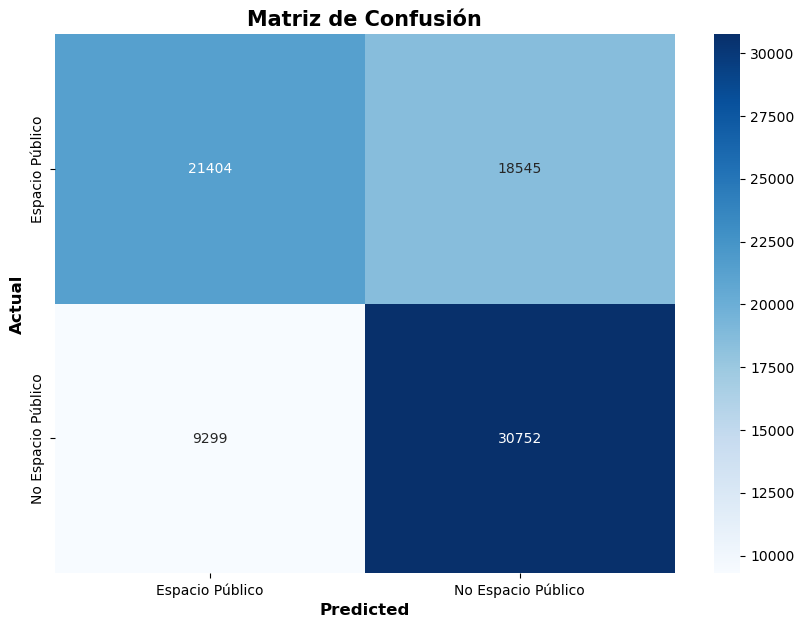

In [21]:
clf = LogisticRegression()
clf.fit(x_train_scale, y_train)
y_pred = clf.predict(x_test_scale)
cm = confusion_matrix(y_test,y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [22]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.65195


### Naive Bayes

In [23]:
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

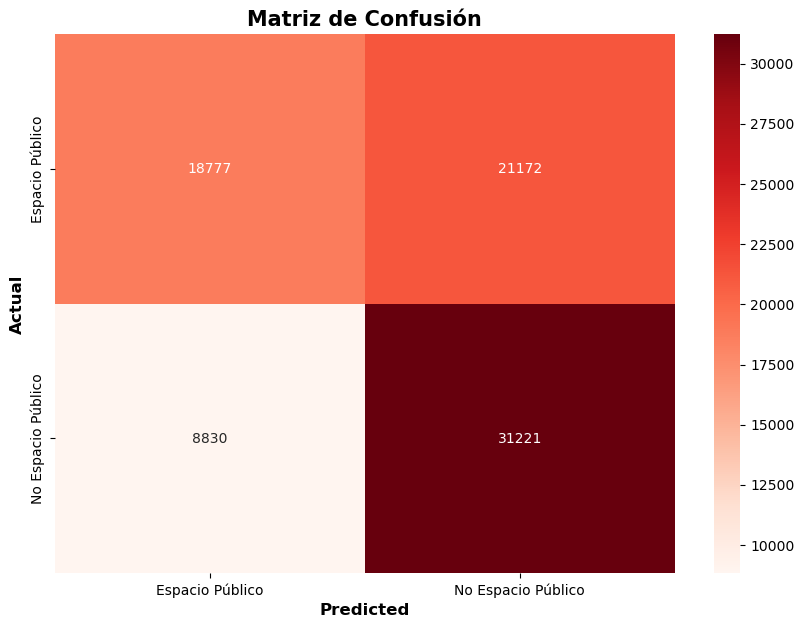

In [24]:
y_prend = nb.predict(x_test)
cm = confusion_matrix(y_test, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [25]:
accuracy = accuracy_score(y_test, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.624975


## Random Forest Classifier (RFC)

In [17]:
rf = RandomForestClassifier(n_estimators=120, random_state=42)  
rf.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_predd = rf.predict(x_test)

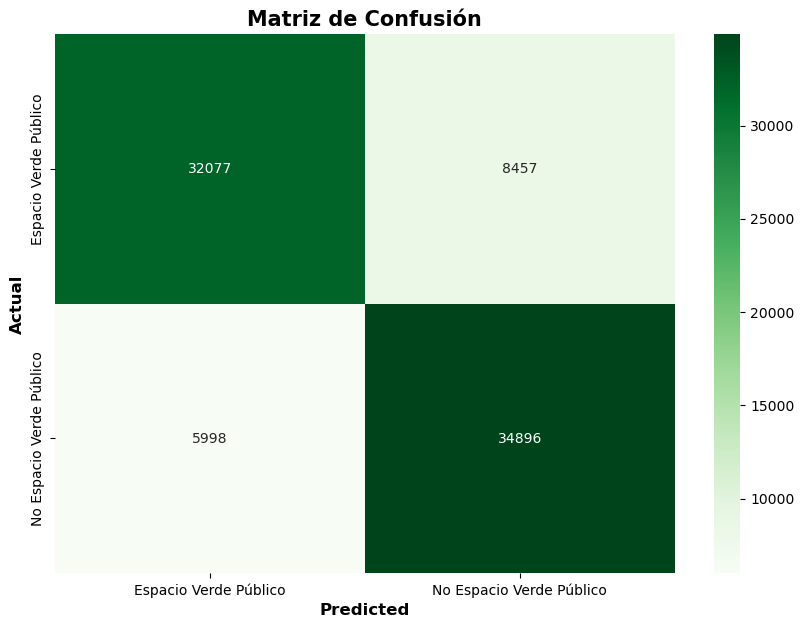

In [18]:
cm = confusion_matrix(y_test, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [19]:
accuracy = accuracy_score(y_test, y_predd)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8224812103944589


### Optimización Hiperparámetros para obtener la mejor combinación

#### GridSearch

In [21]:
param_grid = { 
    'n_estimators': [25, 50, 100, 125, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
}  

In [25]:
#grid_search = GridSearchCV(RandomForestClassifier(), 
                         #  param_grid=param_grid) 
#grid_search.fit(x_train, y_train) 
#print(grid_search.best_estimator_) 
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid, n_iter=10, n_jobs=-1)
random_search.fit(x_train, y_train)
print(random_search.best_estimator_)


KeyboardInterrupt



In [ ]:
rf = RandomForestClassifier(n_estimators=120, random_state=42)  
rf.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_predd = rf.predict(x_test)

## XGBoost

In [18]:
xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Ajustar el modelo a los datos de entrenamiento
xgb_classifier.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_predict = xgb_classifier.predict(x_test)

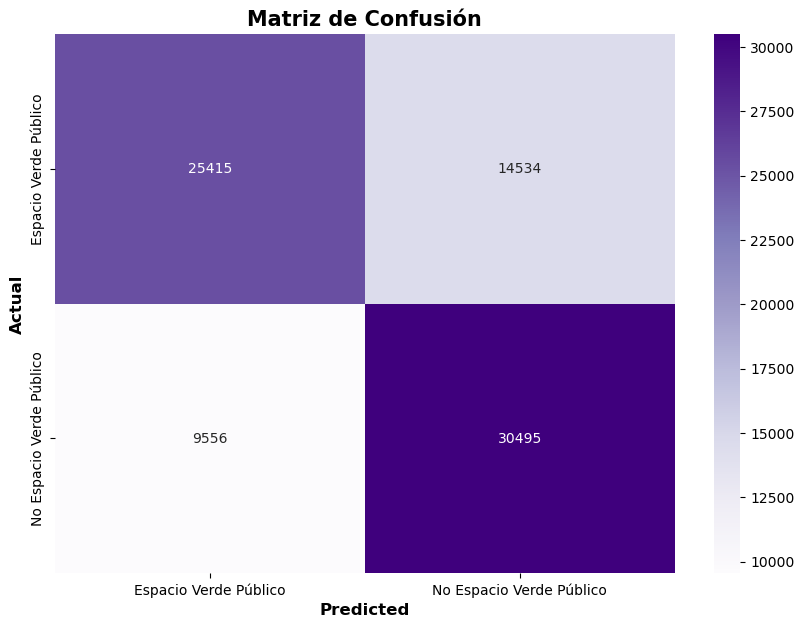

In [19]:
cm = confusion_matrix(y_test, y_predict)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [20]:
accuracy = accuracy_score(y_test, y_predict)
print(f'Accuracy: {accuracy}')

Accuracy: 0.698875


Podemos observar que al tener menos datos la clasificación con Naive Bayes, XGBoost y Regresión logística salió peor que con toda la información. Sin embargo, el random forest classifier es el que mejor, ha predecido con un 82% de precisión.

## Clasificación del modelo Perceptrón

In [ ]:
n_clases = len(y.unique())
n_features = len(x.columns)

x = x.values
output_y = y.values

# Define MLP model
clf = Sequential()
clf.add(Dense(180, input_dim=n_features, activation='relu'))
clf.add(Dense(180, activation='relu'))
clf.add(Dense(1, activation='sigmoid')) 

# Compile model
clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit model
clf.fit(x, output_y, epochs=30, batch_size=10)


# Evaluate model with crossvalidation
kf = StratifiedKFold(n_splits=5, shuffle = True)

cv_y_test = []
cv_y_pred = []

for train_index, test_index in kf.split(x, y):

    x_train = x[train_index, :]
    y_train = y[train_index]

    x_test = x[test_index, :]
    y_test = y[test_index]

    # Training phase
    clf_cv = Sequential()
    clf_cv.add(Dense(180, input_dim=n_features, activation='relu'))
    clf_cv.add(Dense(180, activation='relu'))
    clf_cv.add(Dense(1, activation='sigmoid'))
    clf_cv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    clf_cv.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=30, batch_size=10)

    # Test phase
    x_test = x[test_index, :]
    y_test = y[test_index]
    y_pred = [0 if valor < 0.5 else 1 for valor in clf_cv.predict(x_test)]
    
    cv_y_test.append(y_test)
    cv_y_pred.append(y_pred)

# Results
print(classification_report(np.concatenate(cv_y_test), np.concatenate(cv_y_pred)))

Epoch 1/30
40000/40000 [==============================] - 309s 8ms/step - loss: 0.6103 - accuracy: 0.6567
Epoch 2/30
40000/40000 [==============================] - 308s 8ms/step - loss: 0.5985 - accuracy: 0.6696
Epoch 3/30
40000/40000 [==============================] - 301s 8ms/step - loss: 0.5944 - accuracy: 0.6736
Epoch 4/30
40000/40000 [==============================] - 320s 8ms/step - loss: 0.5917 - accuracy: 0.6760
Epoch 5/30
40000/40000 [==============================] - 368s 9ms/step - loss: 0.5901 - accuracy: 0.6781
Epoch 6/30
40000/40000 [==============================] - 247s 6ms/step - loss: 0.5884 - accuracy: 0.6794
Epoch 7/30
40000/40000 [==============================] - 294s 7ms/step - loss: 0.5871 - accuracy: 0.6809
Epoch 8/30
40000/40000 [==============================] - 258s 6ms/step - loss: 0.5856 - accuracy: 0.6819
Epoch 9/30
40000/40000 [==============================] - 250s 6ms/step - loss: 0.5849 - accuracy: 0.6826
Epoch 10/30
40000/40000 [=====================